#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [104]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# DL Model

In [105]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

    ### activation function
    self.leaky_relu = nn.LeakyReLU()

  # forward pass
  def forward(self,x):
    x = self.leaky_relu(self.input(x))
    x = self.leaky_relu(self.fc1(x))
    x = self.leaky_relu(self.fc2(x))
    return self.output(x)

# Training Function

In [106]:
# global parameter
numepochs = 500

def trainTheModel(train_loader,test_loader, winenet):

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.001)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses

# Split Function

In [107]:
def thresholdSplit(vos):
    # import the data
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
    data = pd.read_csv(url, sep=';')
    data = data[data['total sulfur dioxide'] < 200]  # drop a few outliers

    # z-score all columns except for quality
    cols2zscore = data.columns.drop('quality')
    data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

    # Création de la colonne booléenne
    data['boolQuality'] = 0
    data.loc[data['quality'] > vos, 'boolQuality'] = 1

    # Plot de la distribution des classes en pourcentages
    class_counts = data['boolQuality'].value_counts(normalize=True).sort_index() * 100  # [0, 1] en %
    plt.figure(figsize=(5, 4))
    plt.bar(['0', '1'], class_counts)
    plt.title(f'Distribution des classes pour seuil {vos}')
    plt.xlabel('Classe')
    plt.ylabel('Pourcentage (%)')
    plt.ylim(0, 100)
    plt.grid(True, axis='y')
    plt.show()

    # Conversion en tenseurs
    dataT = torch.tensor(data[cols2zscore].values).float()
    labels = torch.tensor(data['boolQuality'].values).float().unsqueeze(1)

    # Split train/test
    train_data, test_data, train_labels, test_labels = train_test_split(
        dataT, labels, test_size=0.1)

    # PyTorch datasets
    train_data = torch.utils.data.TensorDataset(train_data, train_labels)
    test_data = torch.utils.data.TensorDataset(test_data, test_labels)

    # Dataloaders
    batchsize = 64
    train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

    return train_loader, test_loader


# Create the experiment 

In [108]:
#Threshold to test
value = [4.5, 5.5, 6.5]


=== Threshold: 4.5 ===


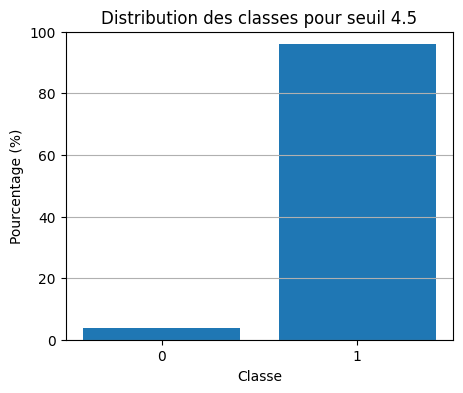

Final train acc: 96.38%
Final test acc: 94.38%


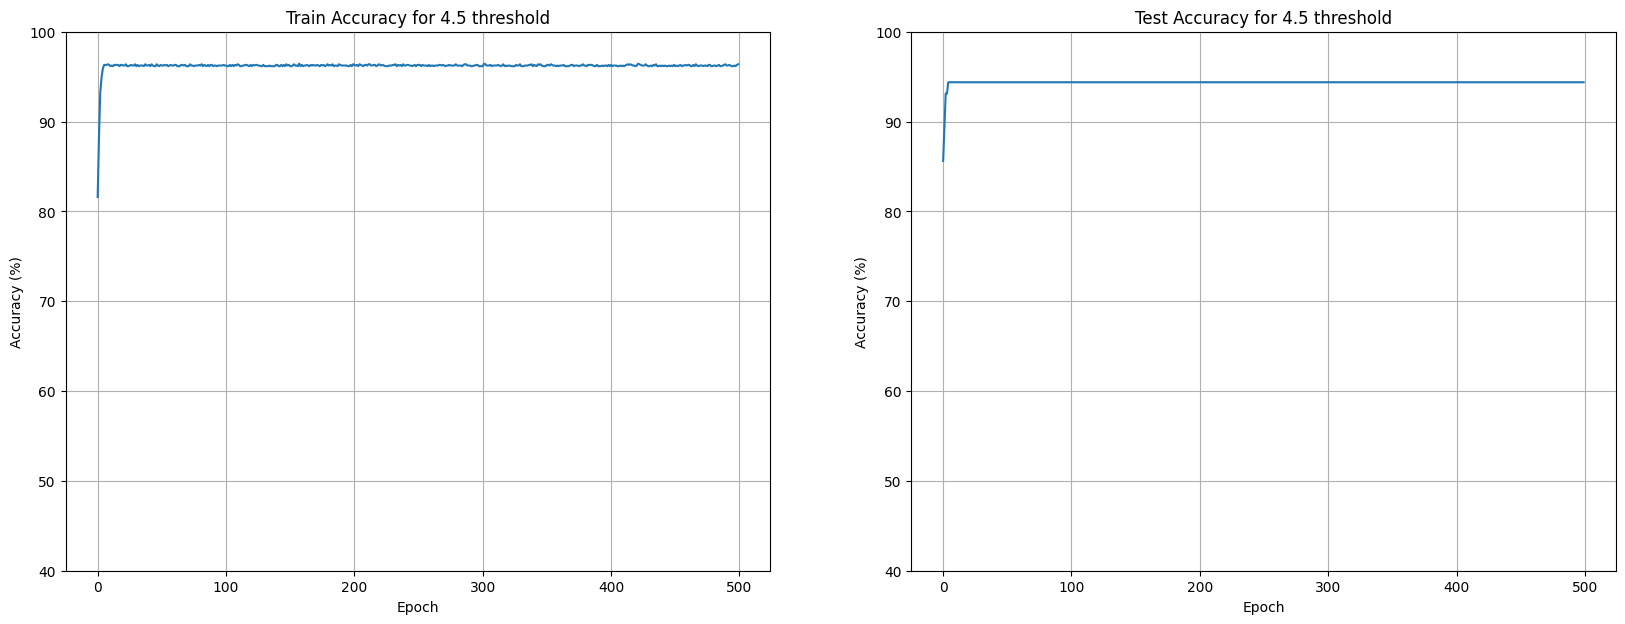


=== Threshold: 5.5 ===


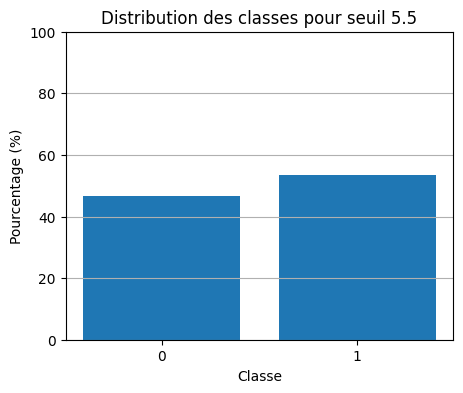

Final train acc: 72.09%
Final test acc: 73.12%


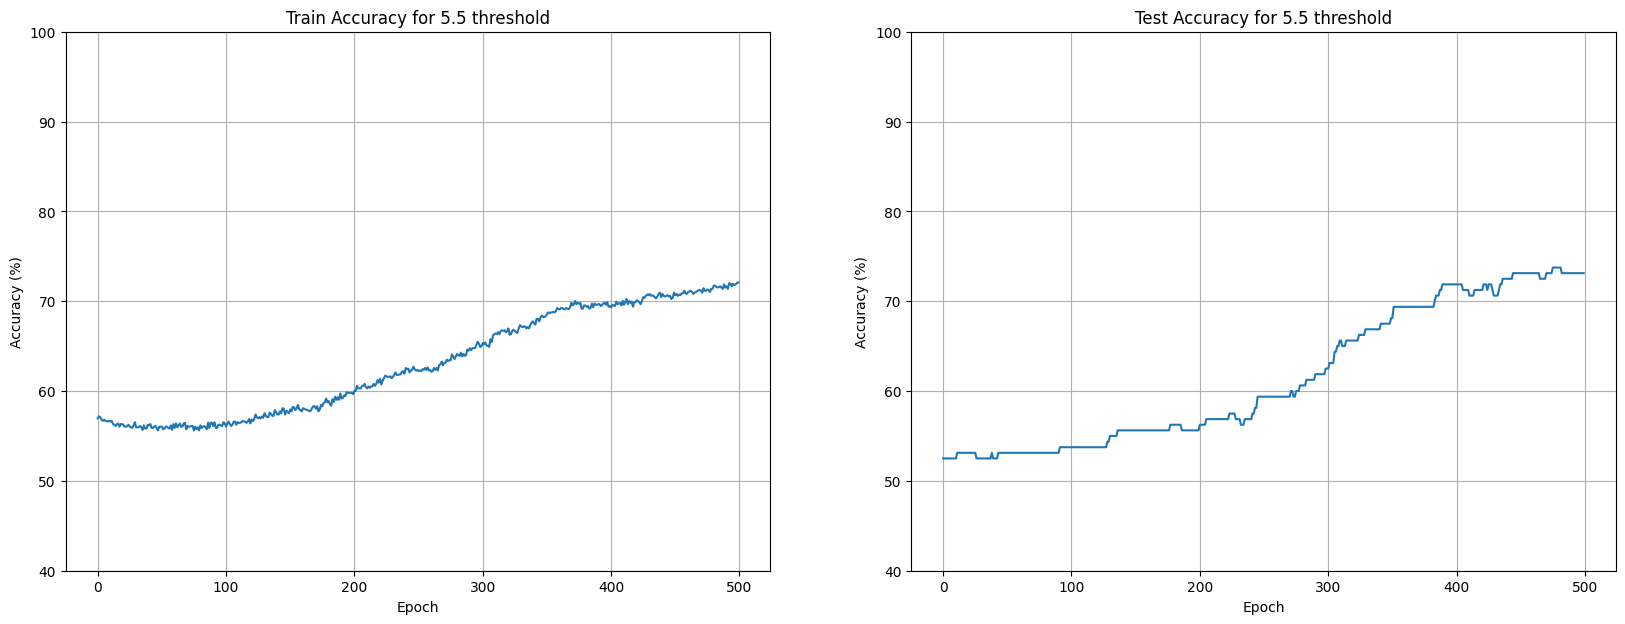


=== Threshold: 6.5 ===


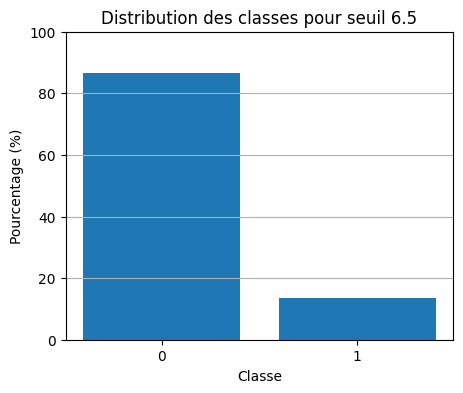

Final train acc: 87.14%
Final test acc: 81.88%


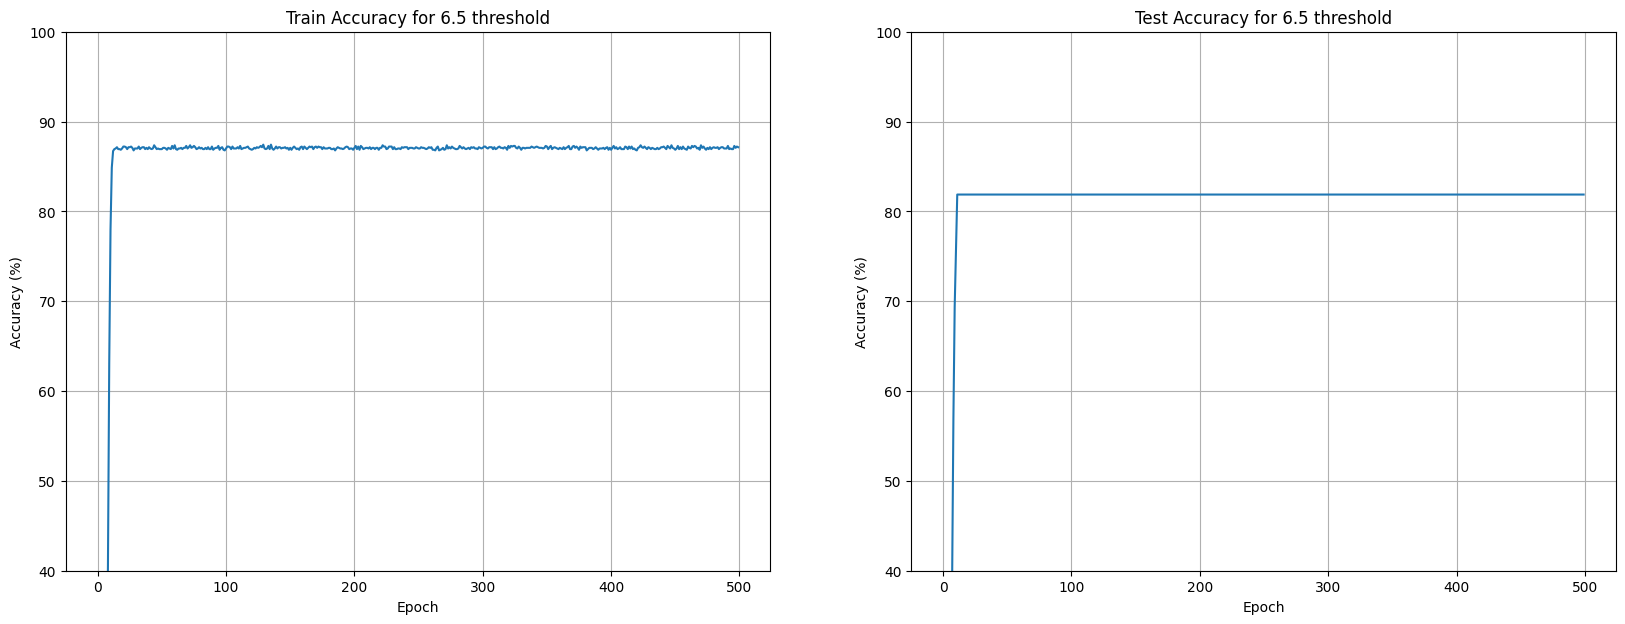

In [109]:
for v in value:
    print(f"\n=== Threshold: {v} ===")
    train_loader, test_loader = thresholdSplit(v)

    winenet = ANNwine()  

    trainAcc, testAcc, losses = trainTheModel(train_loader, test_loader, winenet)

    print(f"Final train acc: {trainAcc[-1]:.2f}%")
    print(f"Final test acc: {testAcc[-1]:.2f}%")
    # Affichage des résultats
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))

    ax[0].plot(trainAcc)
    ax[0].set_title(f'Train Accuracy for {v} threshold')

    ax[1].plot(testAcc)
    ax[1].set_title(f'Test Accuracy for {v} threshold')

    for i in range(2):
        ax[i].set_xlabel('Epoch')
        ax[i].set_ylabel('Accuracy (%)')
        ax[i].set_ylim([40, 100])
        ax[i].grid(True)

    plt.show()
